## Approach

We designed a **Grammar Scoring Engine** to generate continuous grammar scores (ranging from 0 to 5) for spoken audio files.

### Preprocessing

- Audio files in `.wav` format were loaded using `librosa` and converted to mono for consistency across samples.

### Feature Extraction

- Extracted 13 **Mel-frequency cepstral coefficients (MFCCs)** from each file.  
- Computed **mean** and **standard deviation** for each MFCC, yielding a 26-dimensional feature vector per file.

### Model

- Chose a **Random Forest Regressor** due to its stability and interpretability, especially suitable for small datasets (444 samples).

### End-to-End Pipeline

Audio → MFCC Features → Feature Vector → Regressor → Predicted Score

---

## Preprocessing Steps

- All audio inputs were standardized to mono to maintain uniformity.
- No trimming or padding was applied, as summarizing MFCCs naturally accommodates variable audio durations (45–60 seconds).
- The pipeline takes `.wav` file paths from `train.csv` and `test.csv` as input.
- MFCC features were extracted and summarized into mean and standard deviation vectors.
- A Random Forest model was trained on 80% of the training set and validated on the remaining 20%.
- Final predictions (grammar scores) were saved in a le named **submission.csv**.


In [54]:
!pip install librosa

   ---------------------------------------- 0.0/260.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/260.7 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/260.7 kB ? eta -:--:--
   ----------------- ---------------------- 112.6/260.7 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 260.7/260.7 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/64.6 kB ? eta -:--:--
   ---------------------------------------- 64.6/64.6 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 32.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/164.9 kB ? eta -:--:--
   ---------------------------------------- 164.9/164.9 kB 9.7 MB/s eta 0:00:00


In [59]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.0/150.0 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.1/150.0 MB 585.1 kB/s eta 0:04:17
   ---------------------------------------- 0.1/150.0 MB 585.1 kB/s eta 0:04:17
   ---------------------------------------- 0.1/150.0 MB 585.1 kB/s eta 0:04:17
   ---------------------------------------- 0.2/150.0 MB 656.4 kB/s eta 0:03:49
   ---------------------------------------- 0.2/150.0 MB 724.0 kB/s eta 0:03:27
   ---------------------------------------- 0.8/150.0 MB 2.0 MB/s eta 0:01:14
    --------------------------------------- 2.5/150.0 MB 6.0 MB/s eta 0:00:25
   - -------------------------------------- 3.8/150.0 MB 8.3 MB/s eta 0:00:18
   - -------------------------------------- 3.8/150.0 MB 8.3 MB/

In [61]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

In [63]:
np.random.seed(42)

In [67]:
# Load CSV files (adjust paths as needed)
train_df = pd.read_csv(r'C:\Users\Cheshta\Downloads\shl-intern-hiring-assessment\dataset\train.csv')
test_df = pd.read_csv(r'C:\Users\Cheshta\Downloads\shl-intern-hiring-assessment\dataset\test.csv')

# Display sample data
print("Training Data Sample:")
print(train_df.head())
print("\nTest Data Sample:")
print(test_df.head())

# Function to load audio files
def load_audio(file_path):
    """
    Load an audio file using librosa.
    Returns: audio time series, sample rate
    """
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    return audio, sr

# Check audio properties (example for one file)
#sample_path = train_df['filename'].iloc[0]  # Adjust column name if different
#audio, sr = load_audio(sample_path)
#print(f"\nSample Rate: {sr}, Audio Length: {len(audio)/sr} seconds")

Training Data Sample:
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0

Test Data Sample:
         filename
0   audio_706.wav
1   audio_800.wav
2    audio_68.wav
3  audio_1267.wav
4   audio_683.wav


In [71]:
# Base folder where audio files are stored
audio_folder = r'C:\Users\Cheshta\Downloads\shl-intern-hiring-assessment\dataset\audios_train'  # Change if different

# Get sample file path
filename = train_df['filename'].iloc[0]
sample_path = os.path.join(audio_folder, filename)

# Load the audio
audio, sr = load_audio(sample_path)

# Print audio info
print(f"\nSample Rate: {sr}, Audio Length: {len(audio)/sr:.2f} seconds")


Sample Rate: 16000, Audio Length: 60.07 seconds


In [73]:
# Correct base paths
train_audio_path = r'C:\Users\Cheshta\Downloads\shl-intern-hiring-assessment\dataset\audios_train'
test_audio_path = r'C:\Users\Cheshta\Downloads\shl-intern-hiring-assessment\dataset\audios_test'

# Function to load audio
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    return audio, sr

# Function to extract MFCC features
def extract_features(audio, sr):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = mfccs.mean(axis=1)
    mfcc_std = mfccs.std(axis=1)
    return np.concatenate([mfcc_mean, mfcc_std])

# Process training data
X_train = []
y_train = train_df['label'].values

print("Extracting features from training data...")
for file_name in train_df['filename']:
    file_path = os.path.join(train_audio_path, file_name)
    audio, sr = load_audio(file_path)
    features = extract_features(audio, sr)
    X_train.append(features)

X_train = np.array(X_train)
print(f"Training Features Shape: {X_train.shape}")

# Process test data
X_test = []
print("Extracting features from test data...")
for file_name in test_df['filename']:  # make sure the column is 'filename'
    file_path = os.path.join(test_audio_path, file_name)
    audio, sr = load_audio(file_path)
    features = extract_features(audio, sr)
    X_test.append(features)

X_test = np.array(X_test)
print(f"Test Features Shape: {X_test.shape}")

Extracting features from training data...
Training Features Shape: (444, 26)
Extracting features from test data...
Test Features Shape: (195, 26)


In [75]:
# Split training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Initialize and train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_split, y_train_split)

print("Model training completed.")

Model training completed.


In [77]:
# Predict on validation set
y_pred_val = model.predict(X_val)

# Compute evaluation metrics
mse = mean_squared_error(y_val, y_pred_val)
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
pearson_corr, _ = pearsonr(y_val, y_pred_val)

print(f"Validation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")

Validation Metrics:
Mean Squared Error (MSE): 0.9535
Mean Absolute Error (MAE): 0.8020
R-squared (R2): 0.3005
Pearson Correlation: 0.5502


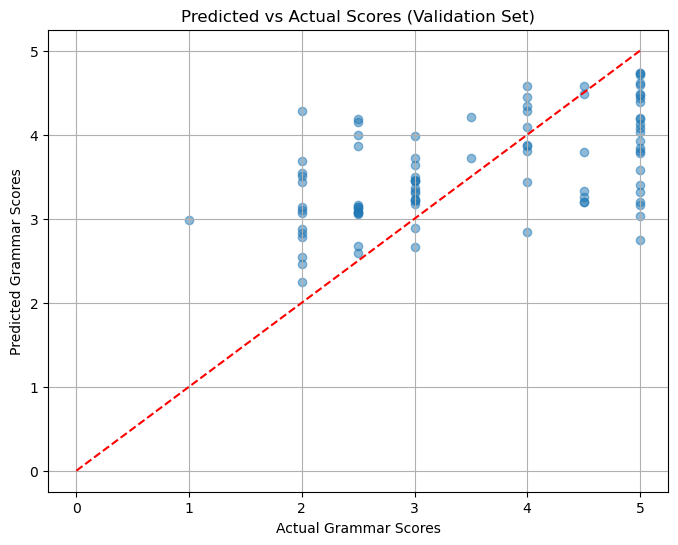

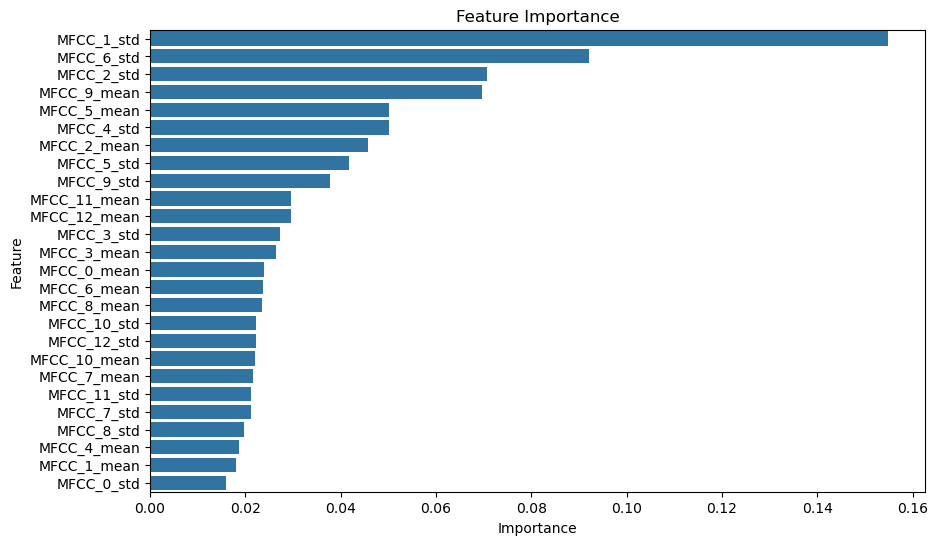

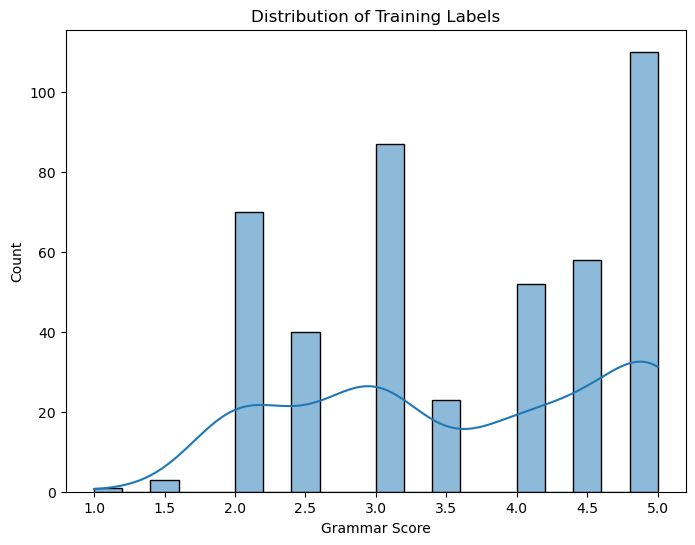

In [79]:
# Scatter plot: Predicted vs Actual Scores
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--')  # Ideal prediction line
plt.xlabel('Actual Grammar Scores')
plt.ylabel('Predicted Grammar Scores')
plt.title('Predicted vs Actual Scores (Validation Set)')
plt.grid(True)
plt.show()

# Feature importance
feature_names = [f'MFCC_{i}_mean' for i in range(13)] + [f'MFCC_{i}_std' for i in range(13)]
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Distribution of training labels
plt.figure(figsize=(8, 6))
sns.histplot(y_train, bins=20, kde=True)
plt.title('Distribution of Training Labels')
plt.xlabel('Grammar Score')
plt.ylabel('Count')
plt.show()

In [81]:
# Predict on test set
y_pred_test = model.predict(X_test)

# Prepare submission file
submission_df = pd.DataFrame({
    'file_path': test_df['filename'],
    'label': y_pred_test
})
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created.")

Submission file 'submission.csv' created.
